# Embeddings on recipes with BERT, Neural Network for classification

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from transformers import BertTokenizer, BertModel, TFBertModel
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

import tensorflow as tf

from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [3]:
# load the restricted dataframe: 5000 recipes, 33% are veg&dessert and 66% are non-veg
df = pd.read_csv('./dataset/recipes_df_r.csv')

In [4]:
df.shape

(10000, 13)

In [5]:
df.head()

,cooking_method,ingredients,recipe_name,tags,Vegetarian&Desserts,Others&D,Vegetarian,Others,Dairy Free,Gluten Free,Low Carb,Low Fat,Low Sodium
0,['Remove the small side muscle from the scallo...,"['1 to 1 1/4 pounds dry sea scallops, approxim...",Seared Scallops,"Scallop Recipes,Shellfish Recipes,Main Dish,Lu...",0,1,0,1,0,1,0,0,0
1,"['With a sharp knife, slit the sausage skins l...","['4 good-quality organic Italian sausages', 'O...",Sausage Carbonara: Linguine alla Carbonara di ...,"Italian,Pasta Recipes,Cheese,Sausage Recipes,M...",0,1,0,1,0,0,0,0,0
2,"['Preheat the oven to 450 degrees F.', 'Cut an...","['1 pound fresh chestnuts', '8 cups coarse fre...",Chestnut Stuffing,"Thanksgiving Stuffing and Dressing,Holiday,Stu...",0,1,0,1,0,0,0,0,0
3,"['Coat pan with 2 teaspoons peanut oil.', 'Com...","['2 (15-ounce) cans black beans, drained and r...","Southwestern Black Bean Cakes with Salsa, Fres...","American,Southwestern,Salsa,Meat,Bacon Recipes...",0,1,0,1,0,0,0,0,0
4,['For the buttermilk strawberry skillet cake: ...,"['5 tablespoons salted butter, at room tempera...",Buttermilk Strawberry Skillet Cake with Strawb...,"Baking,Dessert,Skillet Recipes,Cake,Nut Recipe...",1,0,0,1,0,0,0,0,1


In [6]:
# keep only necessary columns
columns = ['cooking_method', 'ingredients', 'Vegetarian&Desserts', 'Others&D']
df = df[columns]
df.head()

,cooking_method,ingredients,Vegetarian&Desserts,Others&D
0,['Remove the small side muscle from the scallo...,"['1 to 1 1/4 pounds dry sea scallops, approxim...",0,1
1,"['With a sharp knife, slit the sausage skins l...","['4 good-quality organic Italian sausages', 'O...",0,1
2,"['Preheat the oven to 450 degrees F.', 'Cut an...","['1 pound fresh chestnuts', '8 cups coarse fre...",0,1
3,"['Coat pan with 2 teaspoons peanut oil.', 'Com...","['2 (15-ounce) cans black beans, drained and r...",0,1
4,['For the buttermilk strawberry skillet cake: ...,"['5 tablespoons salted butter, at room tempera...",1,0


In [7]:
# take 1000 samples keeping same distribution of feature 'Vegetarian&Desserts'
df_v = df[df['Vegetarian&Desserts'] == 1].sample(n=333)
df_nv = df[df['Others&D'] == 1].sample(n=667)
df = pd.concat([df_v, df_nv])
df = df.sample(frac=1)

df.head()

,cooking_method,ingredients,Vegetarian&Desserts,Others&D
1038,['Heat 1 tablespoon of the oil in large skille...,"['2 tablespoons olive oil, divided', '8 bonele...",0,1
6808,"['For the meatballs: Combine the ground beef, ...","['1 pound ground beef', '1 pound ground pork',...",0,1
5641,"['Preheat the oven to 375 degrees F.', 'In a l...",['6 (6-ounce) boneless skinless chicken breast...,0,1
9556,['Wash and scrub potatoes well. Peel and cut t...,"['6 large Yukon gold potatoes', '3 to 4 cloves...",0,1
5516,"['Directions', 'Blend 2 cups spinach, 1 choppe...",[],1,0


In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

The next cell justifies why we chose `max_length` = 200 in the tokenizer

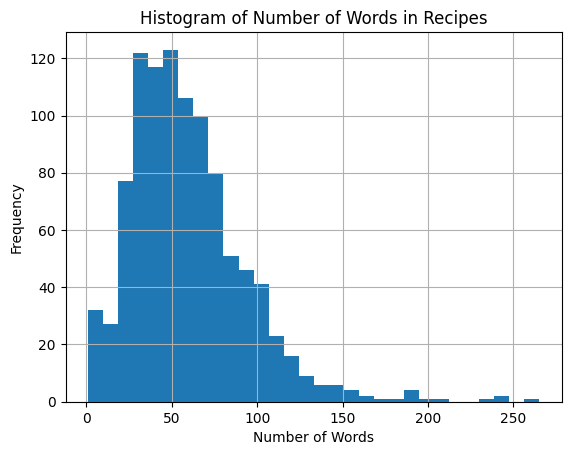

In [9]:
# histogram of the number of words in the recipes
df['num_words'] = df['ingredients'].apply(lambda x: len(x.split()))
df['num_words'].hist(bins=30)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Recipes')
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1038 to 3440
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   cooking_method       1000 non-null   object
 1   ingredients          1000 non-null   object
 2   Vegetarian&Desserts  1000 non-null   int64 
 3   Others&D             1000 non-null   int64 
 4   num_words            1000 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [11]:
# get the cooking_method as a list of strings
cooking_methods = df['cooking_method'].values.tolist()
type(cooking_methods)

list

In [12]:
cooking_methods[0]

"['Heat 1 tablespoon of the oil in large skillet. Season steaks with salt, pepper and thyme and add to hot pan. Sear 2 minutes per side, until golden brown. Add bourbon and cook 1 minute. Add 1/2 cup of the beef broth and bring to a simmer. Cook 2 minutes, until cooked to medium. Remove steaks from pan and transfer 4 of them to a serving platter. Reserve 4 steaks for another meal.', 'Dissolve cornstarch in remaining beef broth and add to pan. Simmer 1 minute, until sauce thickens. Spoon sauce over steaks before serving.', 'In a medium saucepan, bring chicken broth to a boil. Add rice, almonds, cranberries and herb seasoning, reduce heat to low, cover and cook 5 minutes, until liquid is absorbed. Remove from heat, stir in parsley and season with salt and pepper.']"

In [13]:
# Load and preprocess your dataset
X = cooking_methods
y = df['Vegetarian&Desserts'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data using BERT tokenizer
max_length = 200  # Adjust as needed
X_train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
X_val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=max_length, return_tensors='pt')

# Define the model architecture
class CustomClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(CustomClassifier, self).__init__()
        self.bert = bert_model
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 16)
        self.fc2 = nn.Linear(16, 5)
        self.output = nn.Linear(5, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        x = torch.relu(self.fc1(pooled_output))
        x = torch.relu(self.fc2(x))
        logits = self.output(x)
        return logits

# Initialize the model, optimizer, and loss function
model = CustomClassifier(bert_model=bert_model, num_classes=2)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 15  # Adjust as needed
model.train()
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    outputs = model(**X_train_encodings)
    loss = criterion(outputs.logits, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(**X_val_encodings)
    predicted_labels = torch.argmax(outputs.logits, dim=1)
    accuracy = (predicted_labels == y_val).float().mean().item()
    print(f'Validation Accuracy: {accuracy}')

  0%|          | 0/15 [00:00<?, ?it/s]

: 

In [12]:
# Tokenize and encode the recipe texts
max_length = 200  # Maximum sequence length for BERT
encoded_inputs = tokenizer(cooking_methods, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

In [13]:
# Define a simple classifier on top of BERT
class RecipeClassifier(nn.Module):
    def __init__(self, bert_model, num_classes, hidden_size=128, dropout_prob=0.1):
        super(RecipeClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [14]:
# Instantiate the recipe classifier model
num_classes = 2  # Vegetarian or non-vegetarian
recipe_classifier = RecipeClassifier(bert_model, num_classes)

# Perform classification
with torch.no_grad():
    logits = recipe_classifier(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
    probabilities = F.softmax(logits, dim=1)
    predicted_labels = torch.argmax(probabilities, dim=1)

In [15]:
# see data type of predicted_labels
type(predicted_labels)

torch.Tensor

In [16]:
# convert to numpy array
predicted_labels = predicted_labels.numpy()

# consider the column 'Vegetarian&Desserts' as the true labels
true_labels = df['Vegetarian&Desserts'].values
type(true_labels)

numpy.ndarray

In [17]:
# classification report
print(classification_report(true_labels, predicted_labels))

# confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       667
           1       0.00      0.00      0.00       333

    accuracy                           0.67      1000
   macro avg       0.33      0.50      0.40      1000
weighted avg       0.44      0.67      0.53      1000

[[667   0]
 [333   0]]


/Users/irene/VSCodeProjects/HLT-Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irene/VSCodeProjects/HLT-Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irene/VSCodeProjects/HLT-Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

---

## Separate Embeddings and NN

### Prepare the dataset

In [36]:
df = pd.read_csv('./dataset/recipes_df_r.csv')
columns = ['cooking_method', 'ingredients', 'Vegetarian&Desserts']
df = df[columns]

In [ ]:
'''# take 1000 samples keeping same distribution of feature 'Vegetarian&Desserts'
df_v = df[df['Vegetarian&Desserts'] == 1].sample(n=333)
df_nv = df[df['Vegetarian&Desserts'] == 0].sample(n=667)
df = pd.concat([df_v, df_nv])
df = df.sample(frac=1)

df.head()'''

In [37]:
# get the cooking_method as a list of strings
cooking_methods = df['cooking_method'].values.tolist()
type(cooking_methods)

list

In [38]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

'''tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')'''

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

"tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')\nbert_model = BertModel.from_pretrained('bert-base-uncased')"

In [39]:
X = cooking_methods
y = df['Vegetarian&Desserts'].values

# Assuming 'X' contains your input data (cooking methods) and 'y' contains the target labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize input data using BERT tokenizer
max_length = 200  
X_train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
X_val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Obtain BERT embeddings
train_outputs = bert_model(X_train_encodings)
val_outputs = bert_model(X_val_encodings)

: 

In [12]:
# Extract BERT embeddings
train_embeddings = train_outputs.last_hidden_state
val_embeddings = val_outputs.last_hidden_state

In [14]:
train_embeddings.shape, val_embeddings.shape

(TensorShape([800, 200, 768]), TensorShape([200, 200, 768]))

In [15]:
type(train_embeddings)

tensorflow.python.framework.ops.EagerTensor

In [19]:
(train_embeddings.numpy()).shape

(800, 200, 768)

In [17]:
y_train.shape, y_val.shape

((800,), (200,))

In [20]:
# reshape y_train and y_val
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

y_train.shape, y_val.shape

((800, 1), (200, 1))

In [32]:
# Define feedforward neural network for classification using Keras
input_layer = Input(shape=(max_length, 768))  # BERT embedding size is 768
flatten_layer = Flatten()(input_layer)  # Flatten the BERT embeddings
dense_layer1 = Dense(128, activation='relu')(flatten_layer)
dropout_layer = Dropout(0.2)(dense_layer1)
dense_layer2 = Dense(64, activation='relu')(dropout_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer2)  # Assuming binary classification

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_embeddings.numpy(), y_train, epochs=50, batch_size=32, verbose=True)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6681 - loss: 0.6491
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7871 - loss: 0.4767
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8752 - loss: 0.3311
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9237 - loss: 0.2336
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9742 - loss: 0.1596
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9852 - loss: 0.1073
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9967 - loss: 0.0766
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9957 - loss: 0.0542
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 1.0000 - loss: 0.0449
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 0.0383
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 1.0000 - loss: 0.0308
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy:

In [33]:
# predict the output and compare with y_val
predicted_labels = model.predict(val_embeddings.numpy())
predicted_labels = (predicted_labels > 0.5).astype(int)

# classification report
print(classification_report(y_val, predicted_labels))

# confusion matrix
cm = confusion_matrix(y_val, predicted_labels)
print(cm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       118
           1       0.65      0.45      0.53        82

    accuracy                           0.68       200
   macro avg       0.67      0.64      0.64       200
weighted avg       0.67      0.68      0.66       200

[[98 20]
 [45 37]]
